In [1]:
# Core system tools
import os
import gc
import time
import warnings
import shutil

# Numerical and data handling
import numpy as np
import pandas as pd
from time import time
# Image processing
import cv2
import tensorflow as tf
# Plotting
import matplotlib.pyplot as plt

# Model building (TensorFlow/Keras API)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPool2D, SpatialDropout2D, BatchNormalization, 
    GlobalAveragePooling2D, Dense, Dropout, LeakyReLU
)
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Metrics and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")


In [2]:
# Load CSV containing training IDs and labels
meta_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
meta_df["file_name"] = meta_df["id"].apply(lambda v: v + ".tif")

# Equalize class representation by sampling
sample_count = 80000
positive_df = meta_df[meta_df["label"] == 1].sample(n=sample_count)
negative_df = meta_df[meta_df["label"] == 0].sample(n=sample_count)
combined_df = pd.concat([positive_df, negative_df], ignore_index=True)

del positive_df, negative_df


In [3]:
# Split into training and validation sets
train_data, valid_data = train_test_split(
    combined_df, 
    test_size=0.1, 
    stratify=combined_df["label"]
)
train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

train_data["label"] = train_data["label"].astype(str)
valid_data["label"] = valid_data["label"].astype(str)

num_train = train_data.shape[0]
num_valid = valid_data.shape[0]

print("Training data size: {}.".format(num_train))
print("Validation data size: {}.".format(num_valid))

del combined_df
gc.collect()


Training data size: 144000.
Validation data size: 16000.


0

In [18]:
# Configure image generator for preprocessing and augmentation
generator_config = {
    "rescale": 1.0 / 255,
    "samplewise_center": True,
    "samplewise_std_normalization": True,
    "horizontal_flip": True,
    "vertical_flip": True
}
data_generator = ImageDataGenerator(**generator_config)

image_dims = (96, 96, 3)
image_source_dir = "/kaggle/input/histopathologic-cancer-detection/train"
batch_count = 512


In [9]:
# Create generators for training and validation data
train_flow = data_generator.flow_from_dataframe(
    dataframe=train_data,
    directory=image_source_dir,
    x_col="file_name",
    y_col="label",
    has_ext=True,
    target_size=image_dims[:2],
    batch_size=batch_count
)

valid_flow = data_generator.flow_from_dataframe(
    dataframe=valid_data,
    directory=image_source_dir,
    x_col="file_name",
    y_col="label",
    has_ext=True,
    target_size=image_dims[:2],
    batch_size=1,
    shuffle=False
)


Found 144000 validated image filenames belonging to 2 classes.
Found 16000 validated image filenames belonging to 2 classes.


In [11]:
model = Sequential()

model.add(Conv2D(32, (5, 5), padding='same', kernel_initializer=HeNormal(), input_shape=image_dims))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(32, (5, 5), padding='same', kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D())
model.add(SpatialDropout2D(0.3))

model.add(Conv2D(64, (5, 5), padding='same', kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, (5, 5), padding='same', kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D())
model.add(SpatialDropout2D(0.3))

model.add(Conv2D(128, (5, 5), padding='same', kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128, (5, 5), padding='same', kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D())
model.add(SpatialDropout2D(0.3))

model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [21]:
# Define callbacks
lr_schedule = ReduceLROnPlateau(monitor="val_acc", factor=0.5, patience=1, min_lr=1e-5)
early_stopping = EarlyStopping(monitor="val_acc", patience=3, verbose=1, mode= 'max')

start_time = time()

print("Training the model...")
history = model.fit(
    x=train_flow,
    steps_per_epoch=num_train // batch_count,
    epochs=10,
    verbose=1,
    validation_data=valid_flow,
    validation_steps=num_valid,
    callbacks=[lr_schedule, early_stopping]
)

train_duration = time() - start_time
print("Done.")

Training the model...
Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 263s 916ms/step - accuracy: 0.7998 - loss: 0.4417 - val_accuracy: 0.8207 - val_loss: 0.4154 - learning_rate: 0.0010
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 170s 607ms/step - accuracy: 0.8112 - loss: 0.4193 - learning_rate: 0.0010
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 192s 683ms/step - accuracy: 0.8205 - loss: 0.4007 - val_accuracy: 0.8332 - val_loss: 0.3721 - learning_rate: 0.0010
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 114s 408ms/step - accuracy: 0.8252 - loss: 0.3932 - learning_rate: 0.0010
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 51s 183ms/step - accuracy: 0.7422 - loss: 0.5028 - val_accuracy: 0.8419 - val_loss: 0.3569 - learning_rate: 0.0010
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 112s 389ms/step - accuracy: 0.8299 - loss: 0.3865 - learning_rate: 0.0010
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 138s 492ms/step - accuracy: 0.8345 - loss: 0.3739 - val_accuracy: 0.8429 - val_loss: 0.3583 - learning_rate: 0.0010
Epoch 8/10
28

16000/16000 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step

--- Model Summary ---
Validation Accuracy: 0.8624
Validation AUC:      0.9349
Training Time:       1253.62 seconds
Model Parameters:    832,290


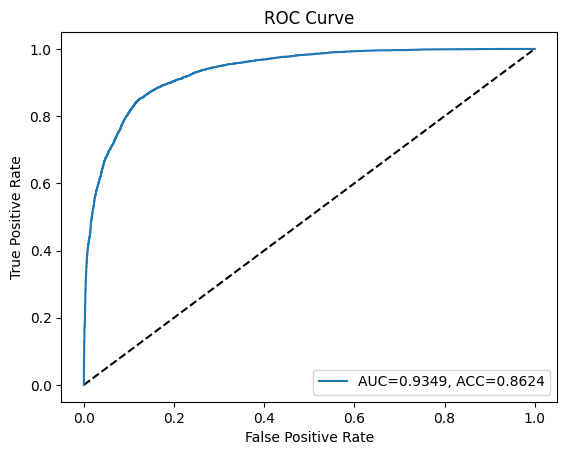

In [23]:
# Evaluate on validation data
val_pred_probs = model.predict(valid_flow, steps=num_valid)[:, 1]
val_true_labels = valid_flow.classes
val_pred_labels = (val_pred_probs > 0.5).astype(int)

val_accuracy = np.mean(val_pred_labels == val_true_labels)
fpr_vals, tpr_vals, _ = roc_curve(val_true_labels, val_pred_probs)
val_auc = auc(fpr_vals, tpr_vals)

print("\n--- Model Summary ---")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation AUC:      {val_auc:.4f}")
print(f"Training Time:       {train_duration:.2f} seconds")
print(f"Model Parameters:    {model.count_params():,}")

# ROC curve
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr_vals, tpr_vals, label=f"AUC={val_auc:.4f}, ACC={val_accuracy:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.savefig("roc_curve.png")
plt.show()


In [30]:
# Load test images
test_path = "/kaggle/input/histopathologic-cancer-detection/test"
test_filenames = [fname for fname in os.listdir(test_path) if fname.endswith(".tif")]
test_frame = pd.DataFrame({"file_name": test_filenames})
test_count = len(test_frame)

# Load submission file
sub_file = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")
sub_file["id"] = sub_file["id"].apply(lambda x: x + ".tif")

# Store all predictions from multiple runs
repeats = 10
for idx in range(repeats):
    test_gen = data_generator.flow_from_dataframe(
        dataframe=test_frame,
        directory=test_path,
        x_col="file_name",
        class_mode=None,
        target_size=image_dims[:2],
        batch_size=1,
        shuffle=False
    )

    current_preds = model.predict(test_gen, steps=test_count, verbose=1)[:, 1]
    pred_frame = pd.DataFrame({
        "id": test_gen.filenames,
        f"label{idx + 1}": current_preds
    })

    sub_file = sub_file.merge(pred_frame, on="id")

# Average the predictions
sub_file["label"] = sub_file[[f"label{i + 1}" for i in range(repeats)]].mean(axis=1)

# Clean up and export
sub_file.drop(columns=[f"label{i + 1}" for i in range(repeats)], inplace=True)
sub_file["id"] = sub_file["id"].apply(lambda x: x.split(".")[0])
sub_file.to_csv("y_pred.csv", index=False)


Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 470s 8ms/step
Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 178s 3ms/step
Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 155s 3ms/step
Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 149s 3ms/step
Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 149s 3ms/step
Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 148s 3ms/step
Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 148s 3ms/step
Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 148s 3ms/step
Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 149s 3ms/step
Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 147s 3ms/step
